In [1]:
import math
import time

import numpy as np
from jax import numpy as jnp

import dvitch as nn
from bench.imaging import show_sample, show_image
from bench.loader import read_idx3_ubyte, read_idx1_ubyte, one_hot_encode, normalize

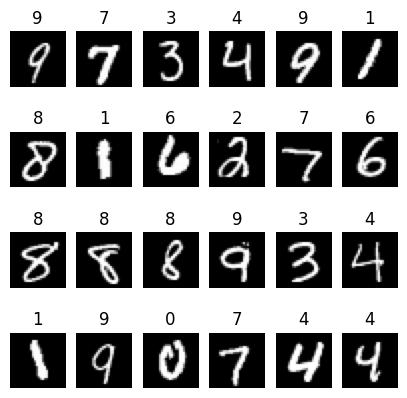

((60000, 28, 28), (60000, 10), (10000, 28, 28), (10000,))

In [2]:
train_images = read_idx3_ubyte("mnist/train-images-idx3-ubyte.gz")
validation_images = read_idx3_ubyte("mnist/t10k-images-idx3-ubyte.gz")
train_labels = read_idx1_ubyte("mnist/train-labels-idx1-ubyte.gz")
validation_labels = read_idx1_ubyte("mnist/t10k-labels-idx1-ubyte.gz")

show_sample(train_images, train_labels)

train_images, _ = normalize(train_images)
validation_images, _ = normalize(validation_images)
train_labels, _ = one_hot_encode(train_labels)

train_images.shape, train_labels.shape, validation_images.shape, validation_labels.shape

In [3]:
model = nn.Sequential(
    nn.Lambda(lambda x: jnp.asarray(x).reshape(-1, 784)),
    nn.Dropout(0.2),
    nn.Linear(784, 512),
    nn.LeakyReLU(),
    nn.Dropout(),
    nn.Linear(512, 256),
    nn.LeakyReLU(),
    nn.Dropout(),
    nn.Linear(256, 10),
    nn.SoftMax(),
)
ep = 5
bs = 256
lr = 0.001
loss_func = nn.CrossEntropyLoss()

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [4]:
print("Start training...")
tm = time.time()
trainer = nn.Trainer(ep, math.ceil(len(train_images) / bs), model)
for e, b in trainer:
    mb = slice(b * bs, (b + 1) * bs)
    loss, g = model.grad(loss_func, train_images[mb], train_labels[mb])
    for k, v in g.items():
        model.get_parameter(k).data -= lr * v.data
    trainer.bbar.set_postfix(loss=f"{loss:.4f}")
print(f"Time: {time.time() - tm:.4f}s", end=" ")

acc = jnp.count_nonzero(
    model(validation_images).argmax(axis=1) == validation_labels
) / len(validation_labels)
lss = loss_func(model(validation_images), one_hot_encode(validation_labels)[0])
print(f"Validation Accuracy: {acc:.4f}, Validation Loss: {lss:.4f}")

acc = jnp.count_nonzero(
    model(train_images).argmax(axis=1) == train_labels.argmax(axis=1)
) / len(train_labels)
lss = loss_func(model(train_images), train_labels)
print(f"Train Accuracy: {acc:.4f}, Train Loss: {lss:.4f}")

Start training...


Epochs:   0%|          | 0/5 [00:00<?, ?epoch/s]

Batches:   0%|          | 0/235 [00:00<?, ?batch/s]

Time: 18.7320s Validation Accuracy: 0.9695, Validation Loss: 1031.0376
Train Accuracy: 0.9705, Train Loss: 5811.5474


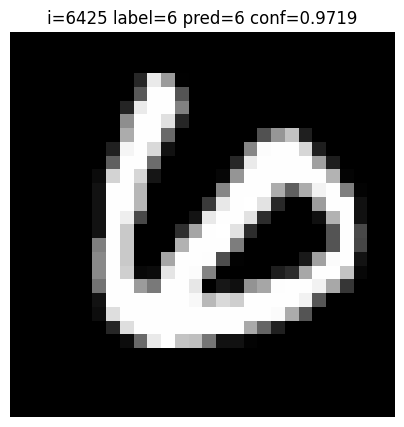

In [5]:
i = int(np.random.randint(0, len(validation_images)))
im = validation_images[i]
label = validation_labels[i]
pred = int(model(im).argmax())
conf = float(model(im).max())
show_image(im, f"{i=} {label=} {pred=} {conf=:.4f}")

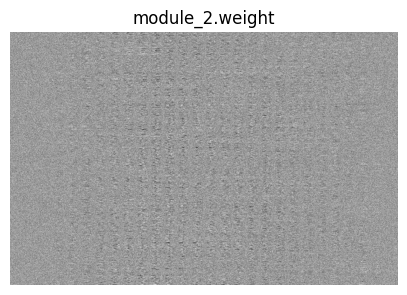

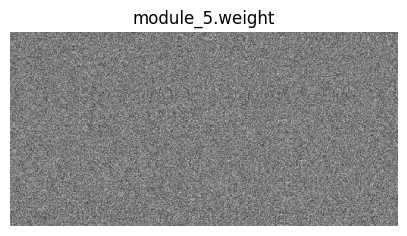

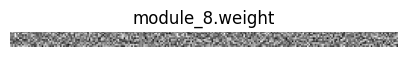

In [6]:
for name, param in model.named_parameters():
    if param.data.ndim >= 2: show_image(param.data, name)